# 퇴근시간 버스승차인원 예측 실습

# 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 

import random
import lightgbm as lgbm 

#경고 미출력
import warnings
warnings.filterwarnings('ignore')

# 지도 관련 시각화
import folium 
from folium.plugins import MarkerCluster 
import geopy.distance 

#processing bar
from tqdm import tqdm_notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 불러오기

In [3]:
train = pd.read_csv('/content/drive/MyDrive/train.csv' ,index_col=0)
test = pd.read_csv('/content/drive/MyDrive/test.csv', index_col=0)
submission = pd.read_csv('/content/drive/MyDrive/submission_sample.csv', index_col=0)

# 2. 데이터 관찰하기

In [4]:
train.head(3)

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [5]:
test.head(3)

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
id,,,,,,,,,,,,,,,,,,,
415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           415423 non-null  object 
 1   bus_route_id   415423 non-null  int64  
 2   in_out         415423 non-null  object 
 3   station_code   415423 non-null  int64  
 4   station_name   415423 non-null  object 
 5   latitude       415423 non-null  float64
 6   longitude      415423 non-null  float64
 7   6~7_ride       415423 non-null  float64
 8   7~8_ride       415423 non-null  float64
 9   8~9_ride       415423 non-null  float64
 10  9~10_ride      415423 non-null  float64
 11  10~11_ride     415423 non-null  float64
 12  11~12_ride     415423 non-null  float64
 13  6~7_takeoff    415423 non-null  float64
 14  7~8_takeoff    415423 non-null  float64
 15  8~9_takeoff    415423 non-null  float64
 16  9~10_takeoff   415423 non-null  float64
 17  10~11_takeoff  415423 non-nul

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 415423 to 643592
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           228170 non-null  object 
 1   bus_route_id   228170 non-null  int64  
 2   in_out         228170 non-null  object 
 3   station_code   228170 non-null  int64  
 4   station_name   228170 non-null  object 
 5   latitude       228170 non-null  float64
 6   longitude      228170 non-null  float64
 7   6~7_ride       228170 non-null  float64
 8   7~8_ride       228170 non-null  float64
 9   8~9_ride       228170 non-null  float64
 10  9~10_ride      228170 non-null  float64
 11  10~11_ride     228170 non-null  float64
 12  11~12_ride     228170 non-null  float64
 13  6~7_takeoff    228170 non-null  float64
 14  7~8_takeoff    228170 non-null  float64
 15  8~9_takeoff    228170 non-null  float64
 16  9~10_takeoff   228170 non-null  float64
 17  10~11_takeoff  228170 no

두 데이터의 <font color="FF99CC">'date',  'in_out',  'station_name' </font>컬럼이 object 타입이다.

****

**💛 데이터 상세 설명**
1. date : 버스 운행 날짜
2. bus_route_id: 버스 노선 ID
3. in_out: 시내버스, 시외버스 구분
4. station_code: 해당 승하차 정류소의 ID
5. station_name: 정류소 이름
6. latitude: 해당 버스 정류장의 위도( 같은 정류장 이름이어도 버스의 진행 방향에 따라 다를 수 있음)
7. longitude: 해당 버스 정류장의 경도( 같은 정류장 이름이어도 버스의 진행 방향에 따라 다를 수 있음)
8. 6~7_ride: 6시부터 6시 59분 59초까지 승차한 인원 수
9. 7~8_ride: 7시부터 7시 59분 59초까지 승차한 인원 수
10. 8~9_ride: 8시부터 8시 59분 59초까지 승차한 인원 수
11. 9~10_ride: 9시부터 9시 59분 59초까지 승차한 인원 수
12. 10~11_ride: 10시부터 10시 59분 59초까지 승차한 인원 수
13. 11~12_ride: 11시부터 11시 59분 59초까지 승차한 인원 수
14. 6~7_takeoff: 6시부터 6시 59분 59초까지 하차한 인원 수
15. 7~8_takeoff: 7시부터 7시 59분 59초까지 하차한 인원 수
16. 8~9_takeoff: 8시부터 8시 59분 59초까지 하차한 인원 수
17. 9~10_takeoff: 9시부터 9시 59분 59초까지 하차한 인원 수
18. 10~11_takeoff: 10시부터 10시 59분 59초까지 하차한 인원 수
19. 11~12_takeoff: 11시부터 11시 59분 59초까지 하차한 인원 수

20. 18~20_ride: 18시부터 19시 59분 59초까지 승차한 인원 수 <font color="3399FF"><- target</font>

# 데이터 전처리

## in_out 컬럼

In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [9]:
train = train.replace('시내', 1)
train = train.replace('시외', 0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           415423 non-null  object 
 1   bus_route_id   415423 non-null  int64  
 2   in_out         415423 non-null  int64  
 3   station_code   415423 non-null  int64  
 4   station_name   415423 non-null  object 
 5   latitude       415423 non-null  float64
 6   longitude      415423 non-null  float64
 7   6~7_ride       415423 non-null  float64
 8   7~8_ride       415423 non-null  float64
 9   8~9_ride       415423 non-null  float64
 10  9~10_ride      415423 non-null  float64
 11  10~11_ride     415423 non-null  float64
 12  11~12_ride     415423 non-null  float64
 13  6~7_takeoff    415423 non-null  float64
 14  7~8_takeoff    415423 non-null  float64
 15  8~9_takeoff    415423 non-null  float64
 16  9~10_takeoff   415423 non-null  float64
 17  10~11_takeoff  415423 non-nul

In [10]:
test = test.replace('시내', 1)
test = test.replace('시외', 0)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 415423 to 643592
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           228170 non-null  object 
 1   bus_route_id   228170 non-null  int64  
 2   in_out         228170 non-null  int64  
 3   station_code   228170 non-null  int64  
 4   station_name   228170 non-null  object 
 5   latitude       228170 non-null  float64
 6   longitude      228170 non-null  float64
 7   6~7_ride       228170 non-null  float64
 8   7~8_ride       228170 non-null  float64
 9   8~9_ride       228170 non-null  float64
 10  9~10_ride      228170 non-null  float64
 11  10~11_ride     228170 non-null  float64
 12  11~12_ride     228170 non-null  float64
 13  6~7_takeoff    228170 non-null  float64
 14  7~8_takeoff    228170 non-null  float64
 15  8~9_takeoff    228170 non-null  float64
 16  9~10_takeoff   228170 non-null  float64
 17  10~11_takeoff  228170 no

# 탐색적 데이터 분석

## 결측치 확인

In [11]:
train.isnull().sum()

date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

In [12]:
test.isnull().sum()

date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64

**시각화로 확인하기**

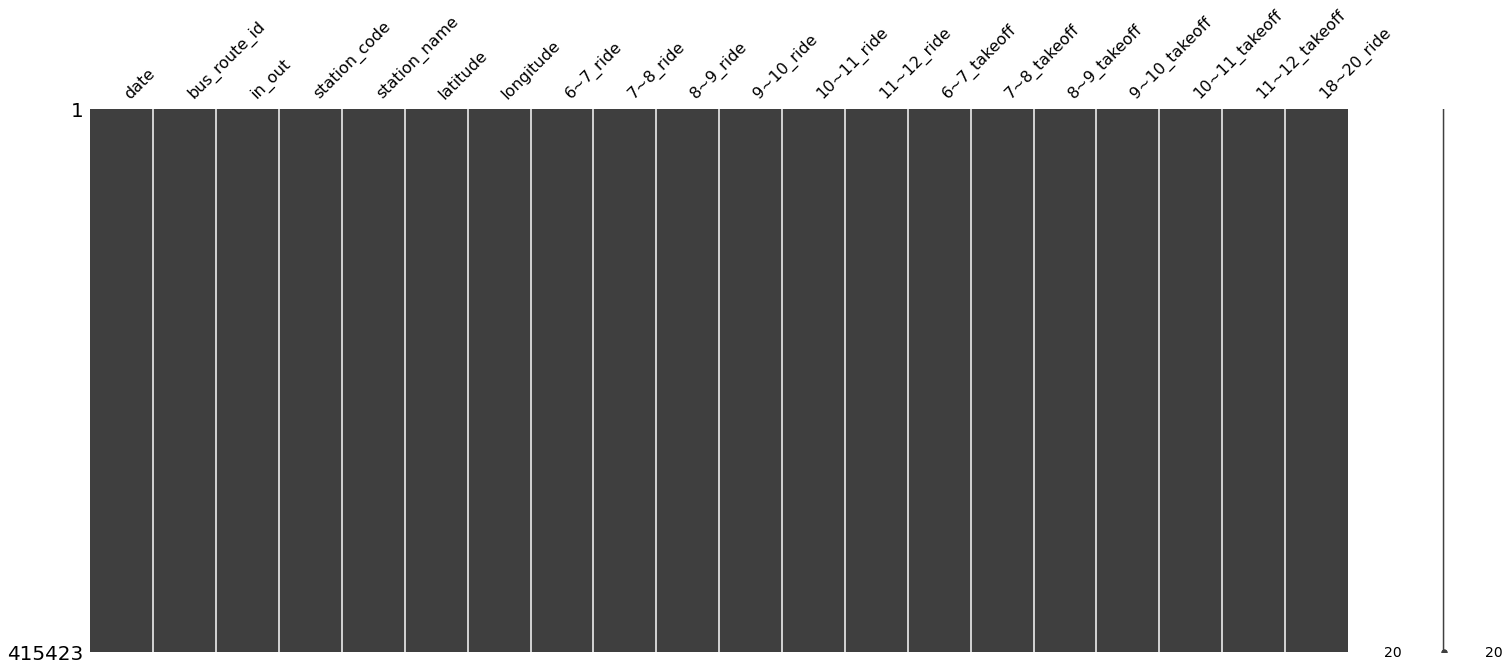

In [13]:
msno.matrix(train)

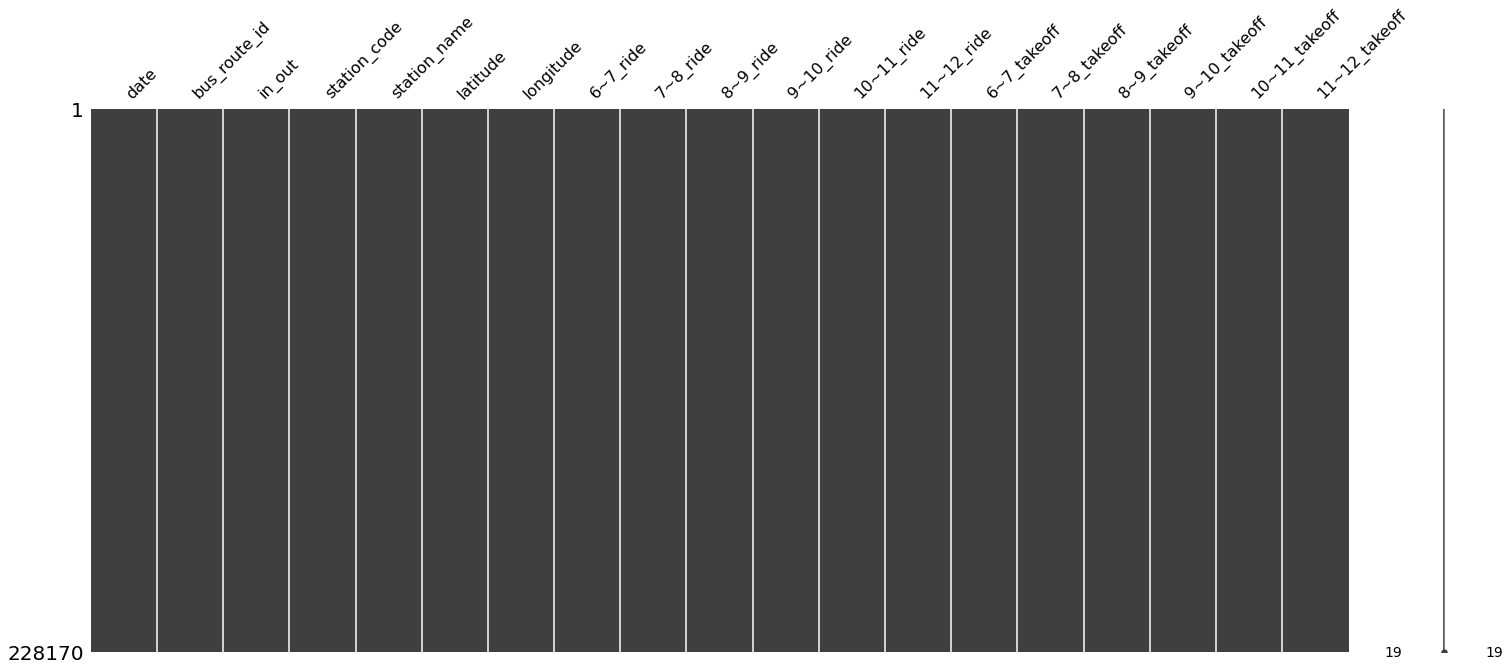

In [14]:
msno.matrix(test)

train 과 test 데이터 모두 결측치가 없다 !

## 상관관계분석

> heatmap
<br/> 변수간 상관관계 표를 그래프로 보여준다.

In [15]:
train_cor = round(train.corr(), 3)
train_cor

,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
bus_route_id,1.000,0.102,-0.016,-0.197,0.010,-0.070,-0.119,-0.128,-0.138,-0.129,-0.129,-0.020,-0.082,-0.102,-0.114,-0.116,-0.112,-0.144
in_out,0.102,1.000,-0.094,-0.009,0.066,-0.027,-0.010,-0.023,-0.025,-0.026,-0.025,-0.027,-0.019,-0.019,-0.018,-0.010,-0.006,-0.022
station_code,-0.016,-0.094,1.000,-0.049,-0.011,0.036,0.055,0.057,0.055,0.051,0.050,-0.003,0.021,0.021,0.023,0.024,0.025,0.034
latitude,-0.197,-0.009,-0.049,1.000,0.134,0.046,0.067,0.066,0.066,0.059,0.060,0.051,0.048,0.056,0.067,0.059,0.058,0.079
longitude,0.010,0.066,-0.011,0.134,1.000,-0.010,-0.016,-0.019,-0.009,-0.008,-0.009,-0.011,-0.021,-0.030,-0.014,-0.008,-0.005,-0.021
6~7_ride,-0.070,-0.027,0.036,0.046,-0.010,1.000,0.376,0.297,0.314,0.279,0.265,0.132,0.032,0.019,0.029,0.030,0.030,0.262
7~8_ride,-0.119,-0.010,0.055,0.067,-0.016,0.376,1.000,0.480,0.427,0.395,0.390,0.069,0.184,0.130,0.106,0.117,0.136,0.372
8~9_ride,-0.128,-0.023,0.057,0.066,-0.019,0.297,0.480,1.000,0.506,0.458,0.453,0.085,0.122,0.304,0.192,0.175,0.206,0.445
9~10_ride,-0.138,-0.025,0.055,0.066,-0.009,0.314,0.427,0.506,1.000,0.537,0.518,0.126,0.145,0.195,0.339,0.246,0.242,0.494
10~11_ride,-0.129,-0.026,0.051,0.059,-0.008,0.279,0.395,0.458,0.537,1.000,0.542,0.118,0.144,0.196,0.242,0.360,0.268,0.513


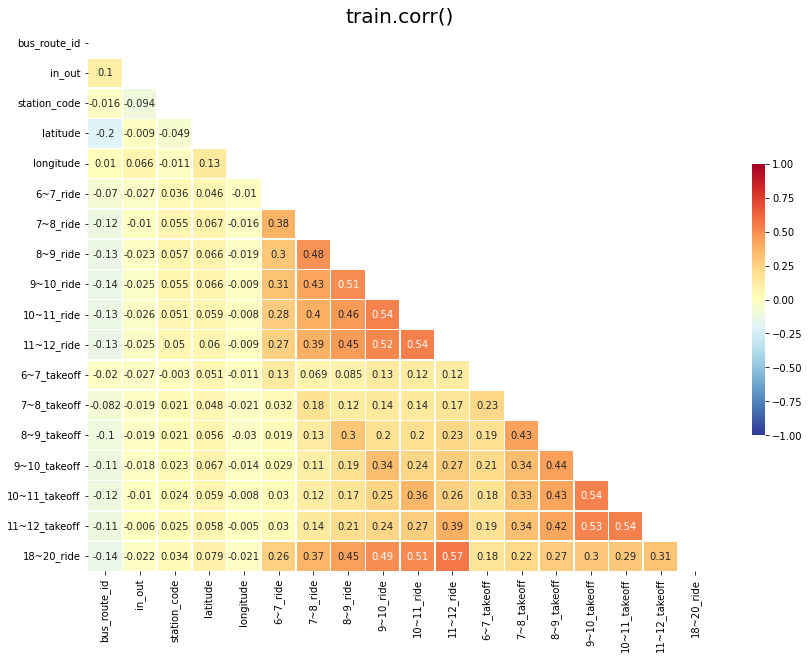

In [16]:
# 그림 사이즈를 지정한다.
fig, ax = plt.subplots( figsize=(14,10) )
plt.title('train.corr()', size=20)
plt.xticks(rotation=45)

# heatmap은 대각선 중심으로 양쪽이 대칭으로 동일한 값을 가지므로 한쪽 삼각형만 보여준다.
mask = np.zeros_like(train_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다.
sns.heatmap(train_cor,
            annot=True, 
            mask = mask,
            cmap='RdYlBu_r',
            linewidth=.5,
            cbar_kws={"shrink": .5},
            vmin = -1, vmax = 1)
plt.show()

<font color="3399F">"18~20_ride" </font>컬럼과 상관관계를 보이는 컬럼들은 <font color="red">?!</font>
- 8~9_ride
- 9~10_ride
- 10~11_ride
- 11~12_ride

<br/>🚌 오전 8시부터 11시 59분 59초 사이에 승차한 인원과 상관관계를 보인다.

## 요일별 버스 승하차 인원 파악

현제 데이터 상태 확인

In [17]:
train.head()

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,0,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-09-01,4270000,0,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2019-09-01,4270000,0,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2019-09-01,4270000,1,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,2019-09-01,4270000,1,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


시간대별 버스 승하차 인원 컬럼 생성

In [18]:
ride_col_list = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
                 '10~11_ride', '11~12_ride', '18~20_ride']
takeoff_col_list = ['6~7_takeoff', '7~8_takeoff', '8~9_takeoff', 
                    '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride']

날짜별 시간대별 승하차 인원 합

In [19]:
df_date_ride = train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns = ['date', 'ride_time', 'count']
df_date_ride['date_disp'] = df_date_ride['date'].apply(lambda x: x[5:]) # 년도 제외하고 추출

In [20]:
df_date_ride

,date,ride_time,count,date_disp
0,2019-09-01,6~7_ride,2942.0,09-01
1,2019-09-01,7~8_ride,4518.0,09-01
2,2019-09-01,8~9_ride,5682.0,09-01
3,2019-09-01,9~10_ride,6275.0,09-01
4,2019-09-01,10~11_ride,6774.0,09-01
...,...,...,...,...
205,2019-09-30,8~9_ride,15699.0,09-30
206,2019-09-30,9~10_ride,11803.0,09-30
207,2019-09-30,10~11_ride,10565.0,09-30
208,2019-09-30,11~12_ride,9505.0,09-30


In [21]:
df_date_takeoff = train.groupby(['date']).sum()[takeoff_col_list].stack().reset_index()
df_date_takeoff.columns = ['date', 'takeoff_time', 'count']
df_date_takeoff['date_disp'] = df_date_takeoff['date'].apply(lambda x: x[5:])
df_date_takeoff.head(5)

,date,takeoff_time,count,date_disp
0,2019-09-01,6~7_takeoff,1343.0,09-01
1,2019-09-01,7~8_takeoff,2713.0,09-01
2,2019-09-01,8~9_takeoff,3671.0,09-01
3,2019-09-01,9~10_takeoff,4077.0,09-01
4,2019-09-01,10~11_takeoff,4510.0,09-01


Text(0, 0.5, '인원수')

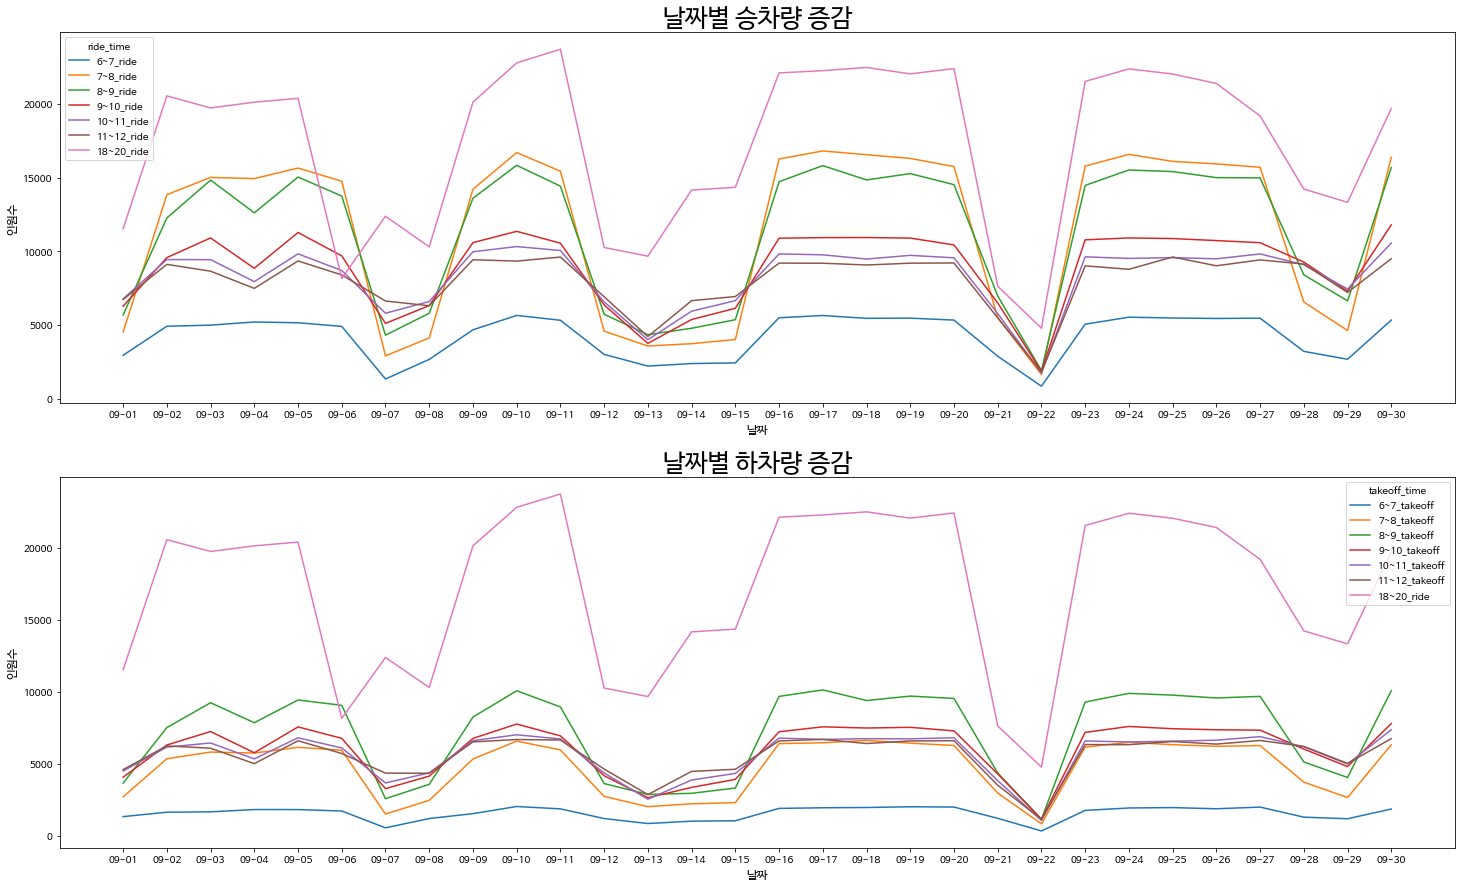

In [22]:
plt.figure(figsize=(25,15))
plt.rc('font', family = 'NanumBarunGothic')

plt.subplot(2,1,1)
sns.lineplot(x='date_disp', y='count', hue='ride_time', data=df_date_ride)
plt.title('날짜별 승차량 증감', size=25)
plt.xlabel('날짜', size=12)
plt.ylabel('인원수', size=12)

plt.subplot(2,1,2)
sns.lineplot(x='date_disp', y='count', hue='takeoff_time', data=df_date_takeoff)
plt.title('날짜별 하차량 증감', size=25)
plt.xlabel('날짜', size=12)
plt.ylabel('인원수', size=12)

2019년 공휴일 리스트 생성

In [23]:
holidays = ['01-01', '02-04', '02-05', '02-06', '03-01', '05-05', '05-06', '05-12', '06-06', '08-15',
            '09-12', '09-13', '09-14', '10-03', '10-09', '12-25']
holidays = ['2019-'+day for day in holidays]

평일, 주말, 공휴일 구분하기


||striptime|strftime|
|:----|:---------|:---------|
|용도|주어진 포맷에 따라 객체를 문자열로 변환|주어진 해당 포맷으로 문자열을 datetime 객체로 구문 분석|
|메서드형|인스턴스 메서드|클래스 메서드|

****
**strptime()** [연/월/일]
<br/>%Y : 연도(4자리) <font color="3399FF">ex. 2020  </font>
<br/>%y : 연도(끝 두자리) <font color="3399FF">ex. 20 </font>
<br/>%m : 월 <font color="3399FF">ex.01</font>
<br/>%d : 일 <font color="3399FF">ex.31</font>
<br/>%h : 영문 달 이름 <font color="3399FF">ex. Feb</font>

**strftime()**
<br/>%a : 요일 축약형 <font color="3399FF">ex. Mon  </font>
<br/>%A : 요일 <font color="3399FF">ex. Monday </font>
<br/>%w : 요일 10진수 <font color="3399FF">ex. 1(월요일)</font>
<br/>%b : 월 축약형 <font color="3399FF">ex. Feb</font>
<br/>%p : 오전, 오후 <font color="3399FF">ex. AM</font>
 ****
더 자세한 포맷 코드를 원한다면, 아래 링크로!
<br/>https://docs.python.org/ko/3/library/datetime.html#strftime-and-strptime-format-codes


In [24]:
train['weekday'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%A"))
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in ['Saturday', 'Sunday'] else row.holiweekend, axis=1)

In [25]:
train[['date', 'weekday', 'holiday', 'holiweekend']]

,date,weekday,holiday,holiweekend
id,,,,
0,2019-09-01,Sunday,N,WE
1,2019-09-01,Sunday,N,WE
2,2019-09-01,Sunday,N,WE
3,2019-09-01,Sunday,N,WE
4,2019-09-01,Sunday,N,WE
...,...,...,...,...
415418,2019-09-30,Monday,N,N
415419,2019-09-30,Monday,N,N
415420,2019-09-30,Monday,N,N


In [26]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [27]:
# 요일별 시간대별 승차 인원(평균)
df_week_ride = train.groupby(['weekday']).mean()[ride_col_list[:-1]].stack().reset_index()
df_week_ride.columns = ['weekday', 'ride_time', 'count']
df_week_ride.head(10)

,weekday,ride_time,count
0,Friday,6~7_ride,0.321627
1,Friday,7~8_ride,0.894317
2,Friday,8~9_ride,0.855104
3,Friday,9~10_ride,0.619050
4,Friday,10~11_ride,0.576228
5,Friday,11~12_ride,0.561128
6,Monday,6~7_ride,0.328862
7,Monday,7~8_ride,0.988160
8,Monday,8~9_ride,0.913985
9,Monday,9~10_ride,0.692790


In [28]:
# 요일별 시간대별 하차 인원(평균)
df_week_takeoff = train.groupby(['weekday']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_week_takeoff.columns = ['weekday', 'takeoff_time', 'count']
df_week_takeoff.tail(10)

,weekday,takeoff_time,count
32,Tuesday,8~9_takeoff,0.620581
33,Tuesday,9~10_takeoff,0.476048
34,Tuesday,10~11_takeoff,0.421016
35,Tuesday,11~12_takeoff,0.407171
36,Wednesday,6~7_takeoff,0.124013
37,Wednesday,7~8_takeoff,0.399699
38,Wednesday,8~9_takeoff,0.582432
39,Wednesday,9~10_takeoff,0.447656
40,Wednesday,10~11_takeoff,0.411336
41,Wednesday,11~12_takeoff,0.399035


In [29]:
# 월요일(0) ~ 일요일(6)
df_week_ride['order'] = df_week_ride['weekday'].apply(lambda x: weekday_order.index(x))
df_week_ride=df_week_ride.sort_values(by=['order'])
df_week_ride.head(10)

,weekday,ride_time,count,order
11,Monday,11~12_ride,0.597506,0
6,Monday,6~7_ride,0.328862,0
7,Monday,7~8_ride,0.988160,0
8,Monday,8~9_ride,0.913985,0
9,Monday,9~10_ride,0.692790,0
10,Monday,10~11_ride,0.638344,0
30,Tuesday,6~7_ride,0.344035,1
31,Tuesday,7~8_ride,1.027342,1
32,Tuesday,8~9_ride,0.978366,1
35,Tuesday,11~12_ride,0.567236,1


In [30]:
df_week_takeoff['order'] = df_week_takeoff['weekday'].apply(lambda x: weekday_order.index(x))
df_week_takeoff=df_week_takeoff.sort_values(by=['order'])
df_week_takeoff.tail(10)

,weekday,takeoff_time,count,order
16,Saturday,10~11_takeoff,0.385856,5
15,Saturday,9~10_takeoff,0.372804,5
14,Saturday,8~9_takeoff,0.330094,5
12,Saturday,6~7_takeoff,0.090464,5
22,Sunday,10~11_takeoff,0.367729,6
18,Sunday,6~7_takeoff,0.098198,6
19,Sunday,7~8_takeoff,0.209709,6
21,Sunday,9~10_takeoff,0.345446,6
23,Sunday,11~12_takeoff,0.376700,6
20,Sunday,8~9_takeoff,0.300899,6


요일별 승하차량 추이

Text(0, 0.5, 'count')

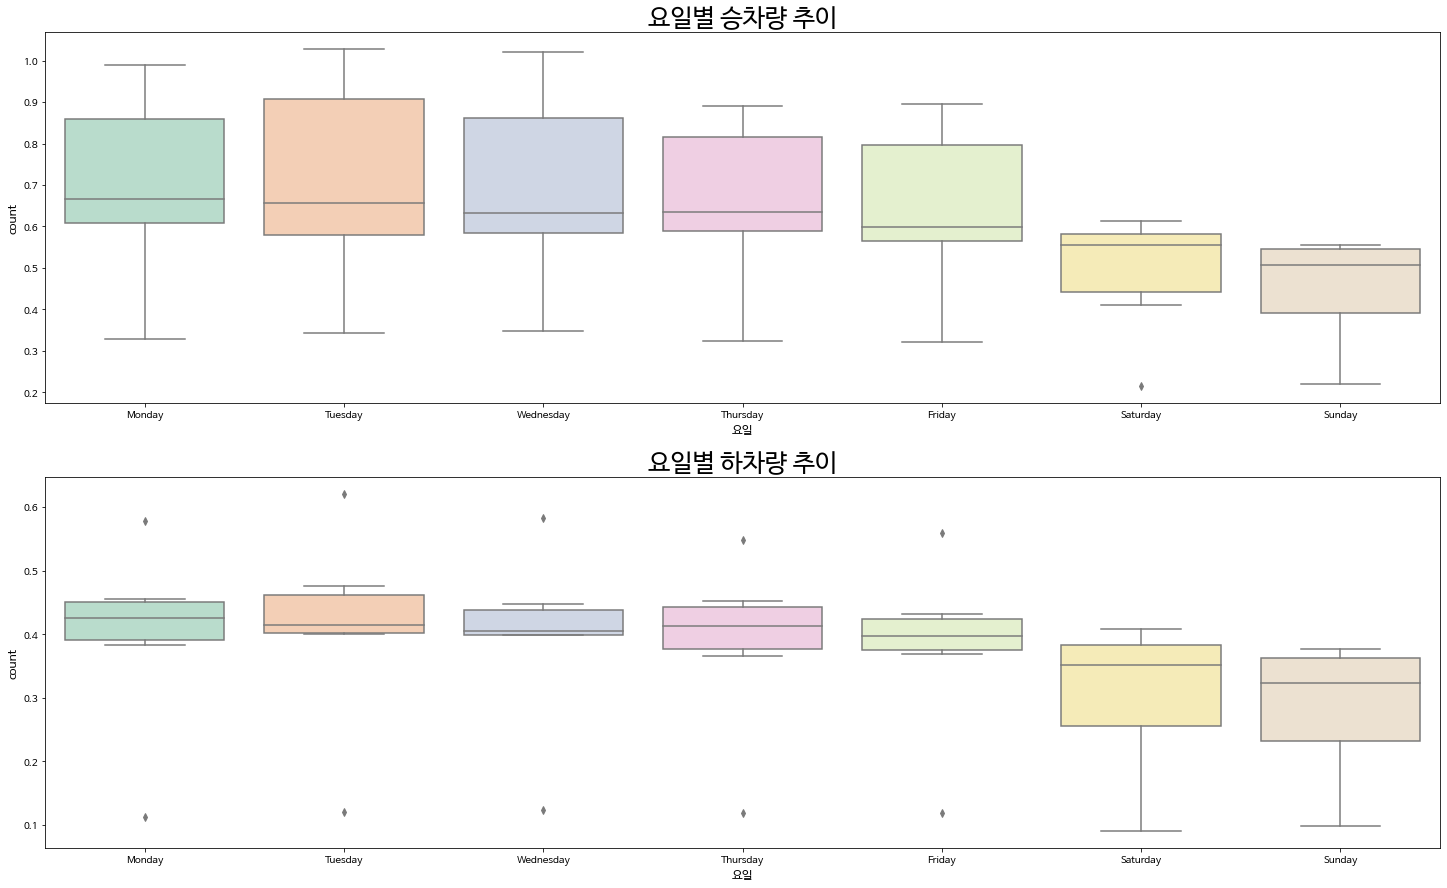

In [31]:
plt.figure(figsize=(25,15))
plt.rc('font', family = 'NanumBarunGothic')
palette = sns.color_palette("Pastel2", 7)

plt.subplot(2,1,1)
sns.boxplot(x='weekday', y='count', data=df_week_ride, palette = palette)
plt.title('요일별 승차량 추이', size=25)
plt.xlabel('요일', size=12)
plt.ylabel('count', size=12)

plt.subplot(2,1,2)
sns.boxplot(x='weekday', y='count', data=df_week_takeoff, palette = palette)
plt.title('요일별 하차량 추이', size=25)
plt.xlabel('요일', size=12)
plt.ylabel('count', size=12)

평일(N), 주말(WE), 공휴일(H) 승하차량 비교

In [32]:
df_holi_ride = train.groupby(['holiweekend']).mean()[ride_col_list[:-1]].stack().reset_index()
df_holi_ride.columns = ['holiweekend', 'ride_time', 'count']
df_holi_ride.head(10)

,holiweekend,ride_time,count
0,H,6~7_ride,0.247274
1,H,7~8_ride,0.386927
2,H,8~9_ride,0.483414
3,H,9~10_ride,0.504053
4,H,10~11_ride,0.537452
5,H,11~12_ride,0.579023
6,N,6~7_ride,0.338143
7,N,7~8_ride,1.005598
8,N,8~9_ride,0.937893
9,N,9~10_ride,0.681753


In [33]:
df_holi_takeoff = train.groupby(['holiweekend']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_holi_takeoff.columns = ['holiweekend', 'ride_time', 'count']
df_holi_takeoff.tail(10)

,holiweekend,ride_time,count
8,N,8~9_takeoff,0.596110
9,N,9~10_takeoff,0.461054
10,N,10~11_takeoff,0.422800
11,N,11~12_takeoff,0.408717
12,WE,6~7_takeoff,0.094355
13,WE,7~8_takeoff,0.220120
14,WE,8~9_takeoff,0.318854
15,WE,9~10_takeoff,0.363184
16,WE,10~11_takeoff,0.377488
17,WE,11~12_takeoff,0.387368


Text(0, 0.5, 'count')

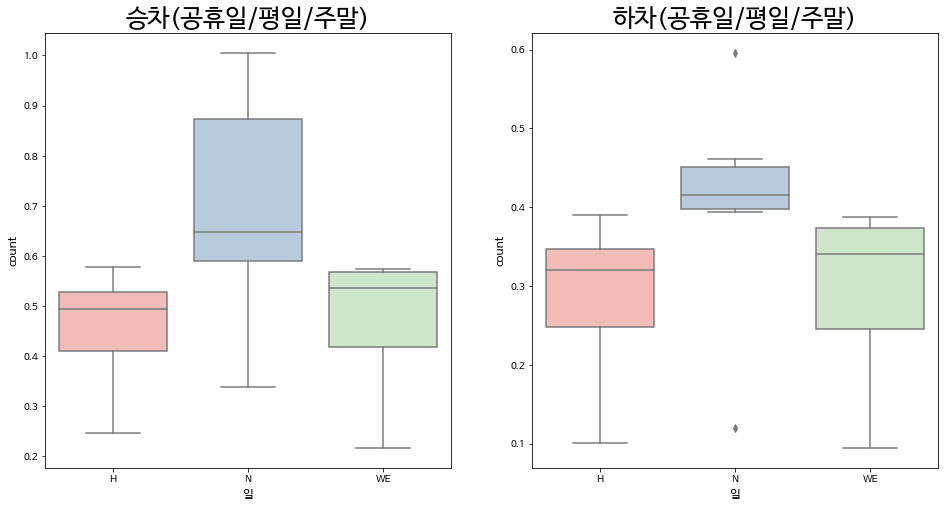

In [34]:
plt.figure(figsize=(16,8))
plt.rc('font', family = 'NanumBarunGothic')
palette = sns.color_palette("Pastel1", 3)

plt.subplot(1,2,1)
sns.boxplot(x='holiweekend', y='count', data=df_holi_ride, palette = palette)
plt.title('승차(공휴일/평일/주말)', size=25)
plt.xlabel('일', size=12)
plt.ylabel('count', size=12)

plt.subplot(1,2,2)
sns.boxplot(x='holiweekend', y='count', data=df_holi_takeoff, palette = palette)
plt.title('하차(공휴일/평일/주말)', size=25)
plt.xlabel('일', size=12)
plt.ylabel('count', size=12)

다른날에 비해 평일 버스 수요가 확실히 높다

## 지도에 표시하기

In [35]:
coords_jejusi = (33.51411, 126.52969) #제주 측정소 근처 위도 경도
coords_seoquipo = (33.24616, 126.5653) #서귀포 측정소 근처 위도 경도
coords_gosan = (33.29382, 126.16283) #고산 측정소 근처 위도 경도
coords_seongsan = (33.38677, 126.8802) #성산 측정소 근처 위도 경도

In [36]:
map_osm= folium.Map((33.399835, 126.506031),zoom_start=10)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=coords_jejusi,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=coords_gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=coords_seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=coords_seoquipo,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [37]:
#정류장의 위치만 확인하기 위해 drop_duplicates() 및 groupby()를 사용함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

# 데이터 전처리

## date 컬럼

날(요일, 평일, 휴일)별 승하차량을 비교한 것을 토대로 전처리 진행

In [41]:
# 전처리를 위해 데이터타입 int로 변경
train['date_week'] = pd.to_datetime(train['date'])
train['weekday'] = train['date_week'].dt.weekday

In [42]:
test['date_week'] = pd.to_datetime(test['date'])
test['weekday'] = test['date_week'].dt.weekday

train 데이터는 2019년 9월, test 데이터는 2019년 10월 데이터다. <br/> 따라서, 19년도 9월, 10월의 공휴일 리스트를 생성한다.

In [43]:
holidays = ['2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09']

평일: N, 주말: WE, 공휴일: H

In [44]:
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)


test['holiday'] = test.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
test['holiweekend'] = test.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in [5,6] else row.holiweekend, axis=1)

In [45]:
train['holiweekend'].value_counts()

N     297247
WE     87457
H      30719
Name: holiweekend, dtype: int64

In [46]:
test['holiweekend'].value_counts()

N     153063
WE     50501
H      24606
Name: holiweekend, dtype: int64

In [47]:
coords_jejusi = (33.51411, 126.52969) #제주 측정소 근처 위도 경도
coords_seoquipo = (33.24616, 126.5653) #서귀포 측정소 근처 위도 경도
coords_gosan = (33.29382, 126.16283) #고산 측정소 근처 위도 경도
coords_seongsan = (33.38677, 126.8802) #성산 측정소 근처 위도 경도

위도, 경도 묶어서 lacation 컬럼 생성

In [48]:
train['location'] = train.apply(lambda row: (row.latitude, row.longitude), axis=1)
train['location']

id
0                   (33.4899, 126.49373)
1                  (33.48944, 126.48508)
2                  (33.48181, 126.47352)
3                  (33.50577, 126.49252)
4         (33.255790000000005, 126.4126)
                       ...              
415418             (33.41437, 126.26336)
415419             (33.49946, 126.51479)
415420               (33.231, 126.26273)
415421              (33.46483, 126.3187)
415422             (33.24873, 126.50799)
Name: location, Length: 415423, dtype: object

In [49]:
#정류장의 위치 확인하기 위해 groupby() 사용
station_loc=train[['location','station_name']].drop_duplicates(keep='first')
station_loc

,location,station_name
id,,
0,"(33.4899, 126.49373)",제주썬호텔
1,"(33.48944, 126.48508)",한라병원
2,"(33.48181, 126.47352)",정존마을
3,"(33.50577, 126.49252)",제주국제공항(600번)
4,"(33.255790000000005, 126.4126)",중문관광단지입구
...,...,...
374291,"(33.96252, 126.29429)",대서리
393524,"(33.33595, 126.26332)",저지리알못
397921,"(33.258990000000004, 126.27554)",어썸브리즈


> 제주 위치와 정류소 사이 거리 컬럼

In [50]:
train['dist_jj'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, coords_jejusi).km)

> 서귀포 위치와 정류소 사이 거리 컬럼

In [51]:
train['dist_sp'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, coords_seoquipo).km)

> 고산 위치와 정류소 사이 거리 컬럼

In [52]:
train['dist_gs'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, coords_gosan).km)

> 성산 위치와 정류소 사이 거리 컬럼

In [53]:
train['dist_ss'] = train['location'].apply(lambda x: geopy.distance.geodesic( x, coords_seongsan).km)

In [54]:
train['center_name'] = train[['dist_jj', 'dist_sp', 'dist_gs', 'dist_ss']].apply(lambda row: ['dist_jj', 'dist_sp', 'dist_gs', 'dist_ss'][row.argmin()][5:], axis=1)

> 해당 정류장과 가장 가까운 거리에 있는 곳 이름(제주/서귀포/고산/성산) 지정

test 데이터도 같은 방식으로 진행

In [56]:
#location컬럼 생성.
test['location'] = test.apply(lambda row: (row.latitude, row.longitude), axis=1)

#정류장 위치 확인
data_loc=test[['location','station_name']].drop_duplicates(keep='first')

#제주시
test['dist_jj'] = test['location'].apply(lambda x: geopy.distance.geodesic( x, coords_jejusi).km)
#서귀포시
test['dist_sp'] = test['location'].apply(lambda x: geopy.distance.geodesic( x, coords_seoquipo).km)
#고산
test['dist_gs'] = test['location'].apply(lambda x: geopy.distance.geodesic( x, coords_gosan).km)
#성산
test['dist_ss'] = test['location'].apply(lambda x: geopy.distance.geodesic( x, coords_seongsan).km)

test['center_name'] = test[['dist_jj', 'dist_sp', 'dist_gs', 'dist_ss']].apply(lambda row: ['dist_jj', 'dist_sp', 'dist_gs', 'dist_ss'][row.argmin()][5:], axis=1)

## 시간대별 승하차 인원수 컬럼

상관관계 그래프에서 <font color="3399FF">"18~20_ride"</font> 와 상관관계를 보이는 컬럼을 확인했다.
<br/> 바로, 오전 8시에서 11시 59분 사이의 승차인원이다.
<br/><font color="grey">BaseLine 중급 코드 참고

우선, 1시간 단위로 나뉜 것을 2시간 단위로 묶어주었다.

In [58]:
#train 데이터
#승차
train['68a']=train['6~7_ride']+train['7~8_ride']
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

#하차
train['68b']=train['6~7_takeoff']+train['7~8_takeoff']
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [59]:
#test데이터
#승차
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

#하차
test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

각 시간대별 승하차한 컬럼들만 모아서 데이터프레임 생성

In [60]:
train_time = train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]
train_time

,68a,810a,1012a,68b,810b,1012b,18~20_ride
id,,,,,,,
0,1.0,7.0,8.0,0.0,0.0,0.0,0.0
1,5.0,6.0,11.0,0.0,0.0,0.0,5.0
2,2.0,2.0,0.0,0.0,0.0,0.0,2.0
3,17.0,32.0,30.0,0.0,0.0,0.0,53.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
415418,4.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,4.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,0.0,0.0,0.0,1.0,0.0,0.0,0.0


시각화를 통한 상관관계 분석

In [61]:
time_cor = round(train_time.corr(), 3)
time_cor

,68a,810a,1012a,68b,810b,1012b,18~20_ride
68a,1.000,0.549,0.472,0.172,0.121,0.127,0.394
810a,0.549,1.000,0.640,0.174,0.347,0.282,0.538
1012a,0.472,0.640,1.000,0.200,0.313,0.416,0.617
68b,0.172,0.174,0.200,1.000,0.471,0.398,0.253
810b,0.121,0.347,0.313,0.471,1.000,0.641,0.335
1012b,0.127,0.282,0.416,0.398,0.641,1.000,0.344
18~20_ride,0.394,0.538,0.617,0.253,0.335,0.344,1.000


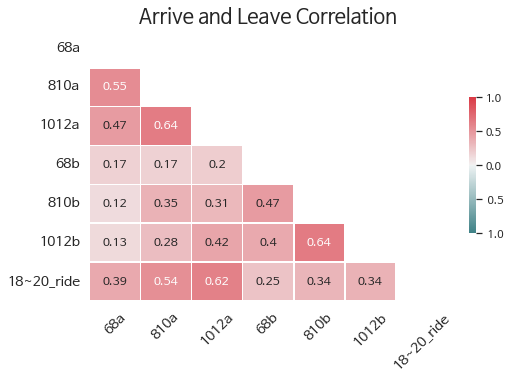

In [62]:
plt.figure(figsize=(8,5))
sns.set(style="white")

plt.rc('font', family = 'NanumBarunGothic')
plt.title('Arrive and Leave Correlation', size=20)
palette = sns.color_palette('twilight') + sns.color_palette('bright')
cmap = sns.diverging_palette(200,10,as_cmap=True)

mask = np.zeros_like(time_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다.
heatmap2 = sns.heatmap(time_cor,
            annot=True,
            mask=mask, 
            cmap=cmap,
            linewidth=.5,
            cbar_kws={"shrink": .5},
            vmin = -1, vmax = 1)

sns.set(font_scale = 1.0)
heatmap2.set_xticklabels(heatmap2.get_xmajorticklabels(),fontsize = 14)
heatmap2.set_yticklabels(heatmap2.get_ymajorticklabels(),fontsize = 14)

plt.xticks(rotation=45)

plt.show()

## 날씨 데이터 추가(외부 데이터)

In [63]:
weather = pd.read_csv('/content/drive/MyDrive/jeju_weather.csv', encoding = 'cp949')
weather.head()

,지점,지점명,일시,기온(°C),강수량(mm)
0,184,제주,2019-09-01 00:00,23.7,NaN
1,184,제주,2019-09-01 01:00,23.7,NaN
2,184,제주,2019-09-01 02:00,23.5,NaN
3,184,제주,2019-09-01 03:00,23.4,NaN
4,184,제주,2019-09-01 04:00,23.4,NaN


In [65]:
weather = weather.drop(['지점', '지점명'], axis = 1)
weather.columns = ['date','temp','precipitation']
weather.head()

,date,temp,precipitation
0,2019-09-01 00:00,23.7,NaN
1,2019-09-01 01:00,23.7,NaN
2,2019-09-01 02:00,23.5,NaN
3,2019-09-01 03:00,23.4,NaN
4,2019-09-01 04:00,23.4,NaN


In [66]:
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['date'].dt.hour
weather['date'] = weather['date'].dt.date

weather.tail()

,date,temp,precipitation,hour
4411,2019-10-16,17.8,NaN,19
4412,2019-10-16,17.0,NaN,20
4413,2019-10-16,16.6,NaN,21
4414,2019-10-16,15.8,NaN,22
4415,2019-10-16,15.9,NaN,23


In [67]:
# 오전 6시 ~ 12시까지의 강수량, 기온을 피쳐로 사용
weather = weather[(weather['hour']>=6)&(weather['hour']<=12)].reset_index(drop=True)
weather = weather.groupby('date')[['precipitation', 'temp']].sum().reset_index()
weather

,date,precipitation,temp
0,2019-09-01,0.0,674.4
1,2019-09-02,92.5,675.1
2,2019-09-03,37.2,686.1
3,2019-09-04,133.4,683.9
4,2019-09-05,7.2,731.5
5,2019-09-06,3.7,757.0
6,2019-09-07,1.6,735.8
7,2019-09-08,10.0,688.0
8,2019-09-09,42.5,753.3
9,2019-09-10,0.0,744.4


'date' 컬럼 데이터 타입 datetime 으로 변환

In [68]:
weather['date'] = pd.to_datetime(weather['date'])

In [69]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

데이터 병합

In [70]:
train = pd.merge(train, weather, on ='date', how='left')
test = pd.merge(test, weather, on ='date', how='left')

In [71]:
train

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,dist_ss,center_name,68a,810a,1012a,68b,810b,1012b,precipitation,temp
0,2019-09-01,4270000,0,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,...,37.713630,jj,1.0,7.0,8.0,0.0,0.0,0.0,0.0,674.4
1,2019-09-01,4270000,0,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,...,38.465822,jj,5.0,6.0,11.0,0.0,0.0,0.0,0.0,674.4
2,2019-09-01,4270000,0,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,...,39.259820,jj,2.0,2.0,0.0,0.0,0.0,0.0,0.0,674.4
3,2019-09-01,4270000,1,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,...,38.386802,jj,17.0,32.0,30.0,0.0,0.0,0.0,0.0,674.4
4,2019-09-01,4270000,1,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,...,45.899140,sp,0.0,0.0,0.0,0.0,1.0,0.0,0.0,674.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,2019-09-30,32820000,1,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,...,57.465292,gs,4.0,0.0,0.0,0.0,0.0,0.0,0.0,678.4
415419,2019-09-30,32820000,1,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,...,36.202951,jj,4.0,0.0,0.0,0.0,0.0,0.0,0.0,678.4
415420,2019-09-30,32820000,1,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,...,60.041783,gs,0.0,0.0,0.0,1.0,0.0,0.0,0.0,678.4
415421,2019-09-30,32820000,1,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,...,52.933244,jj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,678.4


In [72]:
train = pd.get_dummies(train,columns=['weekday'])
test = pd.get_dummies(test,columns=['weekday'])

In [73]:
lbl = LabelEncoder()

cat_cols = ['bus_route_id', 'station_code', 'station_name', 'center_name', 'holiday', 'holiweekend']

for col in tqdm_notebook(cat_cols):
    lbl.fit(train[col])
    train[col] = lbl.transform(train[col])
    
for col in tqdm_notebook(cat_cols):
    lbl.fit(test[col])
    test[col] = lbl.transform(test[col])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [74]:
train.head()

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,1012b,precipitation,temp,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2019-09-01,0,0,321,1481,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,674.4,0,0,0,0,0,0,1
1,2019-09-01,0,0,334,1822,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,674.4,0,0,0,0,0,0,1
2,2019-09-01,0,0,407,1406,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,674.4,0,0,0,0,0,0,1
3,2019-09-01,0,1,1440,1431,33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,674.4,0,0,0,0,0,0,1
4,2019-09-01,0,1,1501,1575,33.25579,126.41260,0.0,0.0,0.0,...,0.0,0.0,674.4,0,0,0,0,0,0,1


# 모델링

In [75]:
target_col = '18~20_ride'
train_label = train[target_col]

train2 = train.drop(['date','latitude','longitude','location'], axis=1)
test2 = test.drop(['date','latitude','longitude','location'], axis=1)

In [76]:
train2 = train2.drop('18~20_ride', axis=1)

In [77]:
train2 = train2.drop(['date_week'], axis = 1)
test2 = test2.drop(['date_week'], axis = 1)

In [78]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 0 to 228169
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   bus_route_id   228170 non-null  int64  
 1   in_out         228170 non-null  int64  
 2   station_code   228170 non-null  int64  
 3   station_name   228170 non-null  int64  
 4   6~7_ride       228170 non-null  float64
 5   7~8_ride       228170 non-null  float64
 6   8~9_ride       228170 non-null  float64
 7   9~10_ride      228170 non-null  float64
 8   10~11_ride     228170 non-null  float64
 9   11~12_ride     228170 non-null  float64
 10  6~7_takeoff    228170 non-null  float64
 11  7~8_takeoff    228170 non-null  float64
 12  8~9_takeoff    228170 non-null  float64
 13  9~10_takeoff   228170 non-null  float64
 14  10~11_takeoff  228170 non-null  float64
 15  11~12_takeoff  228170 non-null  float64
 16  holiday        228170 non-null  int64  
 17  holiweekend    228170 non-nul

In [79]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train2.shape[0]))
lgbm_oof_test = np.zeros((test2.shape[0]))

# Hyperparameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 10000
SEED = 777
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':777,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

# Kfold 
kfolds = KFold(n_splits=n_splits, random_state=777, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook(enumerate( kfolds.split( X = train2, y = train_label ) ) ):
    
    # Train/Valid-set을 정의
    X_train , y_train = train2.iloc[trn_ind], train_label[trn_ind]
    X_valid , y_valid = train2.iloc[val_ind], train_label[val_ind]
    
    # Light GBM
    print("---TRAINING---")
    
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train2','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test2)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits #Fold한 결과 앙상블(평균)

0it [00:00, ?it/s]

---TRAINING---
Training until validation scores don't improve for 50 rounds.
[100]	train2's rmse: 2.21057	valid's rmse: 2.74281
[200]	train2's rmse: 1.93736	valid's rmse: 2.66244
[300]	train2's rmse: 1.78329	valid's rmse: 2.634
[400]	train2's rmse: 1.67919	valid's rmse: 2.61385
[500]	train2's rmse: 1.59064	valid's rmse: 2.59649
[600]	train2's rmse: 1.5184	valid's rmse: 2.58278
[700]	train2's rmse: 1.45904	valid's rmse: 2.57458
[800]	train2's rmse: 1.40951	valid's rmse: 2.56977
[900]	train2's rmse: 1.36554	valid's rmse: 2.56368
[1000]	train2's rmse: 1.32442	valid's rmse: 2.55946
[1100]	train2's rmse: 1.28769	valid's rmse: 2.55693
[1200]	train2's rmse: 1.2546	valid's rmse: 2.55519
[1300]	train2's rmse: 1.22365	valid's rmse: 2.55211
Early stopping, best iteration is:
[1349]	train2's rmse: 1.20935	valid's rmse: 2.55057
---TRAINING---
Training until validation scores don't improve for 50 rounds.
[100]	train2's rmse: 2.21091	valid's rmse: 2.68397
[200]	train2's rmse: 1.9522	valid's rmse: 2.6

In [80]:
# 전체 데이터로 적용
X_train=train2
y_train=train_label
X_test=test2

X_train.shape, y_train.shape, X_test.shape

((415423, 38), (415423,), (228170, 38))

In [81]:
submission[target_col] = model.predict(X_test)

In [83]:
submission[target_col].head()

id
415423     3.479912
415424    10.868182
415425     3.054823
415426    35.471219
415427     1.254349
Name: 18~20_ride, dtype: float64